# **Pre Optimization Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\faultana')

### Set file paths

In [2]:
subreddit = "Ask_Politics"
model = "Llama_3.3_70B_Instruct_scale"

# preprocessed data
import_path = f"output/{subreddit}_new_preprocessing_com_rep.csv"

# classified labels
label_path = f"output/{model}/classification/{model}_{subreddit}_full.csv"
#label_path = f"output/{model}/classification/{model}_{subreddit}_labels_only.csv"

EMI_path = f"output/EMI_input_{subreddit}.csv"

output_path = f"output/{model}/{subreddit}_{model}_filtered_relations.csv"

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
import gurobipy
from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from script_faultana_functions import import_subreddit
from script_faultana_functions import filter_subreddit
from script_faultana_functions import aggregate_interactions_directed
from script_faultana_functions import get_counts_and_shares
from script_faultana_functions import find_max
from script_faultana_functions import build_undirected
from script_faultana_functions import get_submissions
from script_faultana_functions import get_comments_and_replies
from script_faultana_functions import assign_types
from script_faultana_functions import find_relevant_submissions
from script_faultana_functions import match_reply_comment_submission
from script_faultana_functions import preprocess_texts
from script_faultana_functions import import_merge_predicted_labels
from script_faultana_functions import extract_labels_from_probability

###

***
### Import Cleaned Interactions

In [5]:
df = pd.read_csv(import_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time,author_child,ups_child,score_child,downs_child,submission_id,body_parent,author_parent,ups_parent,score_parent,downs_parent,submission_text,author_submission,ups_submission,score_submission
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,So what was wrong with or ?,TehNoff,5.0,5,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,We will be adhering to the AskScience style of...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,We will be adhering to the AskScience style of...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,I was at a conference in November where a grad...,Miss_anthropyy,7.0,7,0.0,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,"Stealing the rules might become a trend now, ...",hygo,4.0,4,0.0,I. Submissions\n\nEvery submission in /r/ask_p...,karmanaut,5.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53774,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,A lot of the replies here are not describing t...,dmntproductions,3.0,3,0.0,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18
53775,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,2023-12-13 01:23:46,Wicked001,1.0,1,0.0,attjcv,1. Most liberal intellectuals have better thin...,erissays,NaN,18,NaN,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0
53776,jufqeli,keipr74,"And, yet, nh state law says that nh presidenti...",Ask_Politics,2023-12-22 21:55:03,whitey9457,1.0,1,0.0,15fn49a,Its not a law. The Democratic Party is a priva...,Chibano,1.0,1,0.0,Got it from this clip here: [https://twitter.c...,dancartopb,1.0,1
53777,kdh8lxx,kfcbk6e,for no good reason There is now a good reason...,Ask_Politics,2023-12-29 00:06:23,PlinyToTrajan,1.0,1,0.0,17rdjdw,I don't understand how people can support Gaz...,white_nerdy,1.0,1,0.0,[removed],viragoria,1.0,1




### Import classified labels / Scales

* Analyze

In [6]:
# import labels and merge + recode labels

data = import_merge_predicted_labels(label_path, df, scale = True)
data

All rows:  53779
Invalid classifications:  6338
Share of lost rows:  0.11785269343052121


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time,author_child,ups_child,score_child,downs_child,submission_id,body_parent,author_parent,ups_parent,score_parent,downs_parent,submission_text,author_submission,ups_submission,score_submission,probability
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,So what was wrong with or ?,TehNoff,5.0,5,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.2
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,We will be adhering to the AskScience style of...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,We will be adhering to the AskScience style of...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,I was at a conference in November where a grad...,Miss_anthropyy,7.0,7,0.0,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,0.7
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,"Stealing the rules might become a trend now, ...",hygo,4.0,4,0.0,I. Submissions\n\nEvery submission in /r/ask_p...,karmanaut,5.0,5,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47436,jo178fh,kc78g52,What??. What if they voted based on constituen...,Ask_Politics,2023-12-06 07:17:48,Potential-Alarm-2716,1.0,1,0.0,14545v7,"So there are countries where, if a politician ...",loselyconscious,2.0,2,0.0,Doesn't that effectively set up a system where...,GTRacer1972,29.0,29,0.9
47437,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,2023-12-06 23:27:36,CoyoteKyle15,2.0,2,0.0,b1fvxd,"Despite how many people communism has killed, ...",maracay1999,NaN,29,NaN,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,0.7
47438,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,2023-12-10 02:15:10,The_Grizzly-,1.0,1,0.0,eufkoe,Here are some pretty good Conservative voices ...,Jabbam,NaN,1,NaN,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,0.9
47439,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,A lot of the replies here are not describing t...,dmntproductions,3.0,3,0.0,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,0.0


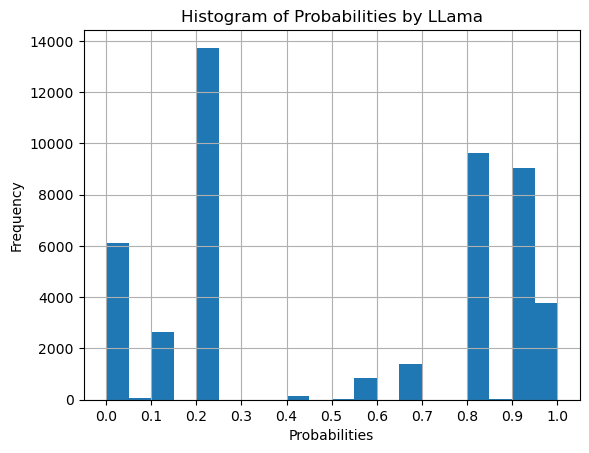

In [7]:
fig, ax = plt.subplots()
ax.hist(data['probability'], bins = 20, range = (0, 1))
ax.set_title("Histogram of Probabilities by LLama")
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) 
#ax.set_xticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"])  
ax.set_xlabel("Probabilities")
ax.set_ylabel("Frequency")
ax.grid(True)

Set threshold to assign labels

In [8]:
extract_labels_from_probability(data, 0.75)

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,submission_text,author_submission,ups_submission,score_submission,probability,label
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.2,pos
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0,pos
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0,pos
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,...,Miss_anthropyy,7.0,7,0.0,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,0.7,pos
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,...,hygo,4.0,4,0.0,I. Submissions\n\nEvery submission in /r/ask_p...,karmanaut,5.0,5,0.1,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47436,jo178fh,kc78g52,What??. What if they voted based on constituen...,Ask_Politics,2023-12-06 07:17:48,Potential-Alarm-2716,1.0,1,0.0,14545v7,...,loselyconscious,2.0,2,0.0,Doesn't that effectively set up a system where...,GTRacer1972,29.0,29,0.9,neg
47437,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,2023-12-06 23:27:36,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,0.7,pos
47438,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,2023-12-10 02:15:10,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,0.9,neg
47439,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,0.0,pos


In [15]:
# needed to be ran later, due to missing cleaning of submissions texts before EMI
#data = preprocess_texts(data = data, length = 5, threshold_child = 100, threshold_parent = 100)
data

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,submission_text,author_submission,ups_submission,score_submission,probability,label
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.2,pos
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0,pos
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,0.0,pos
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,...,Miss_anthropyy,7.0,7,0.0,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,0.7,pos
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,...,hygo,4.0,4,0.0,I. Submissions Every submission in must be A...,karmanaut,5.0,5,0.1,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47436,jo178fh,kc78g52,What??. What if they voted based on constituen...,Ask_Politics,2023-12-06 07:17:48,Potential-Alarm-2716,1.0,1,0.0,14545v7,...,loselyconscious,2.0,2,0.0,Doesn't that effectively set up a system where...,GTRacer1972,29.0,29,0.9,neg
47437,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,2023-12-06 23:27:36,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,0.7,pos
47438,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,2023-12-10 02:15:10,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,0.9,neg
47439,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,0.0,pos


In [16]:
data.to_csv(EMI_path, index = False)

### Edges to interactions (directed)

In [10]:
# get pairwise, directed users interactions
edges_subr = aggregate_interactions_directed(data, two_labels = True, pos_neu = True)
edges_subr

        author_parent          author_child  neg  pos  neu
0      ---BeepBoop---            AuditorTux    0    1    0
1      ---BeepBoop---               cdnpaul    0    1    0
2      -420SmokeWeed-         thisfunnieguy    0    1    0
3               -500-          BearJuden113    1    0    0
4               -500-               Danjour    0    1    0
...               ...                   ...  ...  ...  ...
45687           zvika                eecity    0    1    0
45688      zyadcvnhgb  CoolLikeAFoolinaPool    0    1    0
45689      zyadcvnhgb               Steavee    1    0    0
45690      zyadcvnhgb            cruisintom    0    1    0
45691      zyadcvnhgb         studdbeefpile    1    0    0

[45692 rows x 5 columns]


,author_parent,author_child,neg,pos,neu,edge,#interact
0,---BeepBoop---,AuditorTux,0,1,0,1,1
1,---BeepBoop---,cdnpaul,0,1,0,1,1
2,-420SmokeWeed-,thisfunnieguy,0,1,0,1,1
3,-500-,BearJuden113,1,0,0,-1,1
4,-500-,Danjour,0,1,0,1,1
...,...,...,...,...,...,...,...
45687,zvika,eecity,0,1,0,1,1
45688,zyadcvnhgb,CoolLikeAFoolinaPool,0,1,0,1,1
45689,zyadcvnhgb,Steavee,1,0,0,-1,1
45690,zyadcvnhgb,cruisintom,0,1,0,1,1


### Add node ids

In [13]:
# extracting dictionaries to match user names to ids later

parents_dict = data[['msg_id_parent', 'author_parent']].drop_duplicates()

parents_id_to_name = pd.Series(parents_dict['author_parent'].values, index = parents_dict['msg_id_parent']).to_dict()
parents_name_to_id = pd.Series(parents_dict['msg_id_parent'].values, index = parents_dict['author_parent']).to_dict()


child_dict = data[['msg_id_child', 'author_child']].drop_duplicates()

child_id_to_name = pd.Series(child_dict['author_child'].values, index = child_dict['msg_id_child']).to_dict()
child_name_to_id = pd.Series(child_dict['msg_id_child'].values, index = child_dict['author_child']).to_dict()

names_to_ids = parents_name_to_id.copy()
names_to_ids.update(child_name_to_id)
#names_to_ids

ids_to_names = parents_id_to_name.copy()
ids_to_names.update(child_id_to_name)
#ids_to_names

### Build undirected Network

In [14]:
# default

net_subr = build_undirected(edges_subr, p_init=0, n_init=0)
net_subr

Nr. of bi-directional relations: 607
Nr. of agreeing bi-directional relations: 301
Nr. of disagreeing bi-directional relations: 306
Nr. of uni-directional relations: 44328


c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_final\code\faultana\script_faultana_functions.py:683: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  
c:\Users\3leso\Documents\Elena\Uni\MasterThesis\MasterThesis_final\code\faultana\script_faultana_functions.py:704: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  


,user_1,user_2,neg,neu,pos,interact,final_edge,final_edge_num,direction,neg_adj,pos_adj,interact_adj,mean_pb,variance,old_var,edge_adj
32,-ThePhallus-,sleep-apnea,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.000000,0.000000,0.000000,1.0
73,00rb,gsfgf,1.0,0,1.0,2.0,amb,0,bi,1.0,1.0,2.0,0.500000,0.125000,0.083333,NaN
77,02C_here,AdvocateReason,0.0,0,3.0,3.0,pos,1,bi,0.0,3.0,3.0,1.000000,0.000000,0.000000,1.0
80,02C_here,Whiterabbit--,1.0,0,1.0,2.0,amb,0,bi,1.0,1.0,2.0,0.500000,0.125000,0.083333,NaN
98,1000facedhero,AuditorTux,2.0,0,1.0,3.0,neg,-1,bi,2.0,1.0,3.0,0.333333,0.074074,0.055556,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45537,zvika,eecity,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0
45538,zyadcvnhgb,CoolLikeAFoolinaPool,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0
45539,zyadcvnhgb,Steavee,1.0,0,0.0,1.0,neg,-1,uni,1.0,0.0,1.0,0.000000,0.000000,0.000000,-1.0
45540,zyadcvnhgb,cruisintom,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0


***
## **Descriptive Stats**

In [15]:
print("High Quality Texts:")
print("Edges: ", subreddit)
print("Nr. of replies: ", len(data['msg_id_child'].unique()))
print("Nr. of comments: ", len(data['msg_id_parent'].unique()))
print("Nr. of submissions: ", len(data['submission_id'].unique()))


High Quality Texts:
Edges:  Ask_Politics
Nr. of replies:  47441
Nr. of comments:  32324
Nr. of submissions:  11378


In [16]:
print('Directed Network')


print("Nr. of directed relations: ", len(edges_subr))
print("--------------")

print("Count & Share of one-time vs. multiple: \n", get_counts_and_shares(edges_subr, '#interact'))
print("--------------")

print("Count & Share of one-time vs. multiple: \n", get_counts_and_shares(edges_subr, 'edge'))
print("--------------")

Directed Network
Nr. of directed relations:  45542
--------------
Count & Share of one-time vs. multiple: 
    #interact  Count         %
0          1  44173  0.969940
1          2   1114  0.024461
2          3    183  0.004018
3          4     50  0.001098
4          5     11  0.000242
5          6      7  0.000154
6          7      2  0.000044
7          9      1  0.000022
8          8      1  0.000022
--------------
Count & Share of one-time vs. multiple: 
    edge  Count         %
0     1  23718  0.520794
1    -1  21337  0.468513
2     0    487  0.010693
--------------


In [17]:
print('Undirected Network')

print("Nr. of undirected relations: ", len(net_subr))
print("--------------")

#print(net_subr)



print("Count & Share of bi-directional: \n", get_counts_and_shares(net_subr, 'direction'))
print("--------------")

print("Count & Share of one-time vs. multiple: \n", get_counts_and_shares(net_subr, 'interact'))
print("--------------")


print("Count & Share of edge type: \n", get_counts_and_shares(net_subr, 'final_edge_num'))
print("--------------")

Undirected Network
Nr. of undirected relations:  44935
--------------
Count & Share of bi-directional: 
   direction  Count         %
0       uni  44328  0.986492
1        bi    607  0.013508
--------------
Count & Share of one-time vs. multiple: 
    interact  Count         %
0       1.0  43181  0.960966
1       2.0   1369  0.030466
2       3.0    276  0.006142
3       4.0     64  0.001424
4       5.0     19  0.000423
5       6.0     12  0.000267
6       7.0     10  0.000223
7       9.0      3  0.000067
8      11.0      1  0.000022
--------------
Count & Share of edge type: 
    final_edge_num  Count         %
0               1  23371  0.520107
1              -1  20952  0.466274
2               0    612  0.013620
--------------


In [18]:
# Node counts

authors_child = edges_subr['author_child'].unique().tolist()
print('# Children: ' + str(len(authors_child)))

authors_parent = edges_subr['author_parent'].unique().tolist()
print('# Parents: ' + str(len(authors_parent)))

authors = authors_child + authors_parent
print('# Unique Nodes: ' + str(len(set(authors))))

# Edges
print('# Edges: ' + str(edges_subr['#interact'].sum()))

# Children: 13405
# Parents: 8979
# Unique Nodes: 17929
# Edges: 47278


***
## **Beta Prior Adjusted Edges** 

In [19]:
# adjusted edges, based on 0.6 and 0.4 threshold

get_counts_and_shares(net_subr, 'edge_adj')

,edge_adj,Count,%
0,1.0,23366,0.527354
1,-1.0,20942,0.472646


### Check Distributions

#### Mean_pb

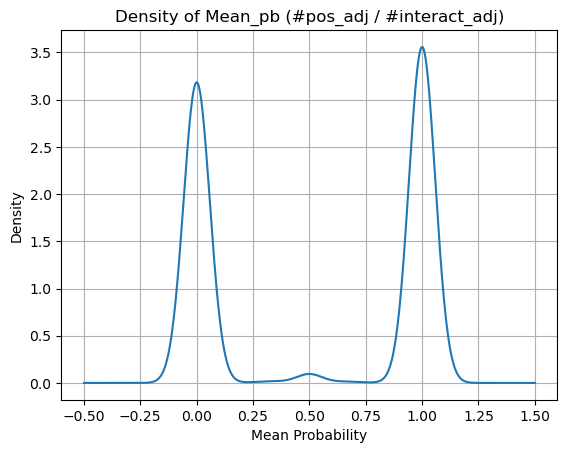

In [20]:
plot = net_subr['mean_pb'].plot(kind = 'kde')
plot.set_title("Density of Mean_pb (#pos_adj / #interact_adj)")
plot.set_xlabel("Mean Probability")
plot.set_ylabel("Density")

plot.grid(True)
plt.show()

**Interpretation:**


* Bump at 0.5
* 0.25 and 0.75 seem to be cut offs



#### Variance

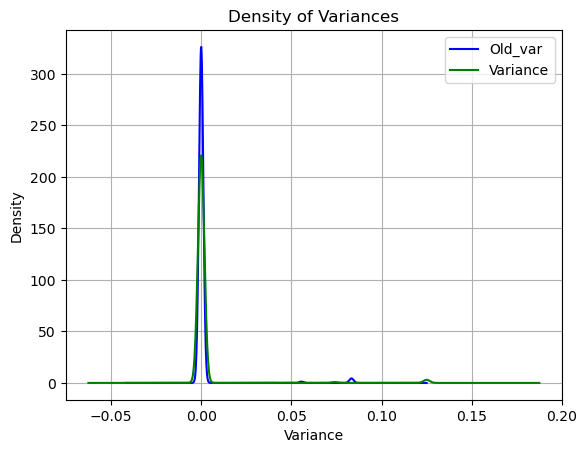

In [21]:
plot = net_subr['old_var'].plot(kind = 'kde', color = "blue", label = "Old_var")
plot = net_subr['variance'].plot(kind = 'kde', color = 'green', label = "Variance")

plot.set_title("Density of Variances")
plot.set_xlabel("Variance")
plot.set_ylabel("Density")

plot.grid(True)
plt.legend(loc = 'upper right')
plt.show()


**Interpretation:**

* My feeling: old variance computation is better.
* Set threshold at 0.025

***
## **Restrict Data**

In [22]:
net_subr[net_subr['old_var'] >= 0.025] 
net_subr[net_subr['old_var'] < 0.025] 

,user_1,user_2,neg,neu,pos,interact,final_edge,final_edge_num,direction,neg_adj,pos_adj,interact_adj,mean_pb,variance,old_var,edge_adj
32,-ThePhallus-,sleep-apnea,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.0,0.0,0.0,1.0
77,02C_here,AdvocateReason,0.0,0,3.0,3.0,pos,1,bi,0.0,3.0,3.0,1.0,0.0,0.0,1.0
243,2343252621,bassadorable,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.0,0.0,0.0,1.0
272,2A_is_the_best_A,Dennis_Langley,4.0,0,0.0,4.0,neg,-1,bi,4.0,0.0,4.0,0.0,0.0,0.0,-1.0
274,2A_is_the_best_A,EbilSmurfs,2.0,0,0.0,2.0,neg,-1,bi,2.0,0.0,2.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45537,zvika,eecity,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0
45538,zyadcvnhgb,CoolLikeAFoolinaPool,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0
45539,zyadcvnhgb,Steavee,1.0,0,0.0,1.0,neg,-1,uni,1.0,0.0,1.0,0.0,0.0,0.0,-1.0
45540,zyadcvnhgb,cruisintom,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [23]:
print("Share of edges to keep: " + str(len(net_subr[((net_subr['mean_pb'] > 0.75) | (net_subr['mean_pb'] < 0.25)) & (net_subr['old_var'] < 0.025)]) / len(net_subr)))
print("Nr. of final interactions: " + str(len(net_subr[((net_subr['mean_pb'] > 0.75) | (net_subr['mean_pb'] < 0.25)) & (net_subr['old_var'] < 0.025)])))

net_subr_filtered = net_subr[((net_subr['mean_pb'] > 0.75) | (net_subr['mean_pb'] < 0.25)) & (net_subr['old_var'] < 0.025)]
net_subr_filtered

Share of edges to keep: 0.981239568265272
Nr. of final interactions: 44092


,user_1,user_2,neg,neu,pos,interact,final_edge,final_edge_num,direction,neg_adj,pos_adj,interact_adj,mean_pb,variance,old_var,edge_adj
32,-ThePhallus-,sleep-apnea,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.0,0.0,0.0,1.0
77,02C_here,AdvocateReason,0.0,0,3.0,3.0,pos,1,bi,0.0,3.0,3.0,1.0,0.0,0.0,1.0
243,2343252621,bassadorable,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.0,0.0,0.0,1.0
272,2A_is_the_best_A,Dennis_Langley,4.0,0,0.0,4.0,neg,-1,bi,4.0,0.0,4.0,0.0,0.0,0.0,-1.0
274,2A_is_the_best_A,EbilSmurfs,2.0,0,0.0,2.0,neg,-1,bi,2.0,0.0,2.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45537,zvika,eecity,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0
45538,zyadcvnhgb,CoolLikeAFoolinaPool,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0
45539,zyadcvnhgb,Steavee,1.0,0,0.0,1.0,neg,-1,uni,1.0,0.0,1.0,0.0,0.0,0.0,-1.0
45540,zyadcvnhgb,cruisintom,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [24]:
get_counts_and_shares(net_subr_filtered, "edge_adj")

,edge_adj,Count,%
0,1.0,23270,0.52776
1,-1.0,20822,0.47224


In [25]:
print("Final Number of users: ", len(set(list(net_subr_filtered.user_1) + list(net_subr_filtered.user_2))))
print("Final Number of edges: ", len(net_subr_filtered))

print("Share of edges per user: ", len(net_subr_filtered)/len(set(list(net_subr_filtered.user_1) + list(net_subr_filtered.user_2))))

Final Number of users:  17909
Final Number of edges:  44092
Share of edges per user:  2.4620023451895694


***
### Add user_ids for optimization and export

In [26]:
# add ids

net_subr_filtered['user_1_id'] = net_subr_filtered['user_1'].map(names_to_ids)
net_subr_filtered['user_2_id'] = net_subr_filtered['user_2'].map(names_to_ids)

In [27]:
net_subr

,user_1,user_2,neg,neu,pos,interact,final_edge,final_edge_num,direction,neg_adj,pos_adj,interact_adj,mean_pb,variance,old_var,edge_adj
32,-ThePhallus-,sleep-apnea,0.0,0,2.0,2.0,pos,1,bi,0.0,2.0,2.0,1.000000,0.000000,0.000000,1.0
73,00rb,gsfgf,1.0,0,1.0,2.0,amb,0,bi,1.0,1.0,2.0,0.500000,0.125000,0.083333,NaN
77,02C_here,AdvocateReason,0.0,0,3.0,3.0,pos,1,bi,0.0,3.0,3.0,1.000000,0.000000,0.000000,1.0
80,02C_here,Whiterabbit--,1.0,0,1.0,2.0,amb,0,bi,1.0,1.0,2.0,0.500000,0.125000,0.083333,NaN
98,1000facedhero,AuditorTux,2.0,0,1.0,3.0,neg,-1,bi,2.0,1.0,3.0,0.333333,0.074074,0.055556,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45537,zvika,eecity,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0
45538,zyadcvnhgb,CoolLikeAFoolinaPool,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0
45539,zyadcvnhgb,Steavee,1.0,0,0.0,1.0,neg,-1,uni,1.0,0.0,1.0,0.000000,0.000000,0.000000,-1.0
45540,zyadcvnhgb,cruisintom,0.0,0,1.0,1.0,pos,1,uni,0.0,1.0,1.0,1.000000,0.000000,0.000000,1.0


In [28]:
net_subr_filtered.to_csv(output_path, index = False)